In [1]:
#!/usr/bin/env python3
# Copyright 2022 ETH Zurich and University of Bologna.
# Licensed under the Apache License, Version 2.0, see LICENSE for details.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.optim as optim
import argparse
import pathlib
import hjson
import random
import os

In [2]:
np.random.seed(42)
torch.manual_seed(42)
global verbose

In [3]:
# download MNIST dataset using DataLoader

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
mnist_dataset = MNIST(PATH_DATASETS, train=True, transform=transform, download=True)

# set seeds for reproducability 
g = torch.Generator()
g.manual_seed(42)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

mnist_dl = DataLoader(mnist_dataset, worker_init_fn=seed_worker, generator=g)

# FP64 training

In [15]:
in_ch = 28*28
out_ch = 10
data_type = torch.float64

class LinLayer(nn.Module):
    def __init__(self):
        super(LinLayer, self).__init__()
        torch.manual_seed(42)
        self.lin = nn.Linear(in_ch, out_ch, dtype=data_type)

    def forward(self, x):
        torch.manual_seed(42)
        out = self.lin(x.view(x.size(0), -1))
        return out

In [11]:
NUM_EPOCHS = 1
NUM_BATCHES = 1
BATCH_SIZE = 256

net = LinLayer()
optimizer = optim.SGD(net.parameters(), lr=0.5)
loss_fn = nn.CrossEntropyLoss()
accuracy = 0
batch_id = 0

loss_vals = []
acc_vals = []

it = iter(mnist_dl)
for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    for i, data in enumerate(mnist_dl, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(torch.float64))

        # determine accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy += (predicted == labels).sum().item()

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % BATCH_SIZE == BATCH_SIZE-1:
            batch_id += 1
            print("Batch: ", batch_id, "Loss: ", loss.item())
            loss_vals.append(loss.item())
            print("Batch: ", batch_id, "Accuracy: ", accuracy / (BATCH_SIZE * NUM_BATCHES))
            acc_vals.append(accuracy / (BATCH_SIZE * NUM_BATCHES))
            accuracy = 0
    
    print("Epoch {} done".format(epoch))

Epoch:  0
Batch:  1 Loss:  2.4784618801701282e-12
Batch:  1 Accuracy:  0.51953125
Batch:  2 Loss:  1.1412164869348901e-05
Batch:  2 Accuracy:  0.6875
Batch:  3 Loss:  0.0
Batch:  3 Accuracy:  0.734375
Batch:  4 Loss:  0.0
Batch:  4 Accuracy:  0.7265625
Batch:  5 Loss:  0.0
Batch:  5 Accuracy:  0.69140625
Batch:  6 Loss:  10.804533702732657
Batch:  6 Accuracy:  0.74609375
Batch:  7 Loss:  0.0
Batch:  7 Accuracy:  0.828125
Batch:  8 Loss:  0.0
Batch:  8 Accuracy:  0.796875
Batch:  9 Loss:  0.0
Batch:  9 Accuracy:  0.83984375
Batch:  10 Loss:  2.0834445280093982e-12
Batch:  10 Accuracy:  0.8671875
Batch:  11 Loss:  14.07773423157634
Batch:  11 Accuracy:  0.8359375
Batch:  12 Loss:  0.0
Batch:  12 Accuracy:  0.8046875
Batch:  13 Loss:  4.195089216520724e-05
Batch:  13 Accuracy:  0.8203125
Batch:  14 Loss:  18.382014248921728
Batch:  14 Accuracy:  0.82421875
Batch:  15 Loss:  0.0
Batch:  15 Accuracy:  0.86328125
Batch:  16 Loss:  3.5527136788004946e-15
Batch:  16 Accuracy:  0.84375
Batch:  

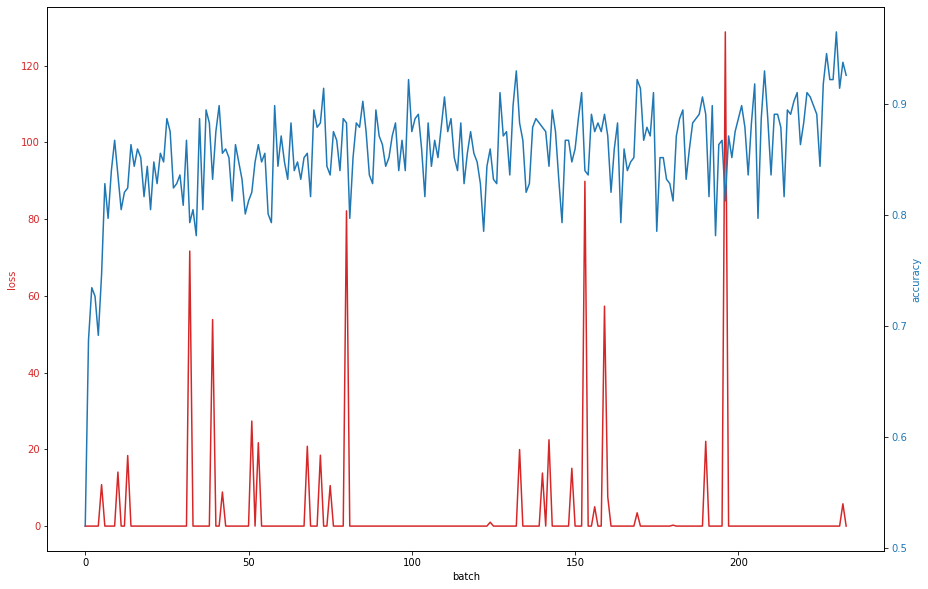

In [14]:
# plot the loss and accuracy next to each other
import matplotlib.pyplot as plt
# change size of plots
plt.rcParams["figure.figsize"] = (15,10)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(loss_vals, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_vals, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# FP32 training

In [17]:
in_ch = 28*28
out_ch = 10
data_type = torch.float32

class LinLayer(nn.Module):
    def __init__(self):
        super(LinLayer, self).__init__()
        torch.manual_seed(42)
        self.lin = nn.Linear(in_ch, out_ch, dtype=data_type)

    def forward(self, x):
        torch.manual_seed(42)
        out = self.lin(x.view(x.size(0), -1))
        return out

In [20]:
NUM_EPOCHS = 1
NUM_BATCHES = 1
BATCH_SIZE = 256

net = LinLayer()
optimizer = optim.SGD(net.parameters(), lr=0.5)
loss_fn = nn.CrossEntropyLoss()
accuracy = 0
batch_id = 0

loss_vals = []
acc_vals = []

it = iter(mnist_dl)
for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    for i, data in enumerate(mnist_dl, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(torch.float32))

        # determine accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy += (predicted == labels).sum().item()

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % BATCH_SIZE == BATCH_SIZE-1:
            batch_id += 1
            print("Batch: ", batch_id, "Loss: ", loss.item())
            loss_vals.append(loss.item())
            print("Batch: ", batch_id, "Accuracy: ", accuracy / (BATCH_SIZE * NUM_BATCHES))
            acc_vals.append(accuracy / (BATCH_SIZE * NUM_BATCHES))
            accuracy = 0
    
    print("Epoch {} done".format(epoch))

Epoch:  0
Batch:  1 Loss:  0.0
Batch:  1 Accuracy:  0.5703125
Batch:  2 Loss:  18.18696403503418
Batch:  2 Accuracy:  0.69921875
Batch:  3 Loss:  0.0
Batch:  3 Accuracy:  0.7109375
Batch:  4 Loss:  0.0
Batch:  4 Accuracy:  0.73828125
Batch:  5 Loss:  0.008096611127257347
Batch:  5 Accuracy:  0.65625
Batch:  6 Loss:  39.14589309692383
Batch:  6 Accuracy:  0.75
Batch:  7 Loss:  0.0
Batch:  7 Accuracy:  0.8515625
Batch:  8 Loss:  0.0
Batch:  8 Accuracy:  0.80078125
Batch:  9 Loss:  0.0
Batch:  9 Accuracy:  0.875
Batch:  10 Loss:  0.0
Batch:  10 Accuracy:  0.859375
Batch:  11 Loss:  0.012457416392862797
Batch:  11 Accuracy:  0.80859375
Batch:  12 Loss:  0.0
Batch:  12 Accuracy:  0.8359375
Batch:  13 Loss:  1.1022928953170776
Batch:  13 Accuracy:  0.796875
Batch:  14 Loss:  24.742023468017578
Batch:  14 Accuracy:  0.828125
Batch:  15 Loss:  0.0
Batch:  15 Accuracy:  0.859375
Batch:  16 Loss:  0.0
Batch:  16 Accuracy:  0.84765625
Batch:  17 Loss:  0.0
Batch:  17 Accuracy:  0.828125
Batch:  1

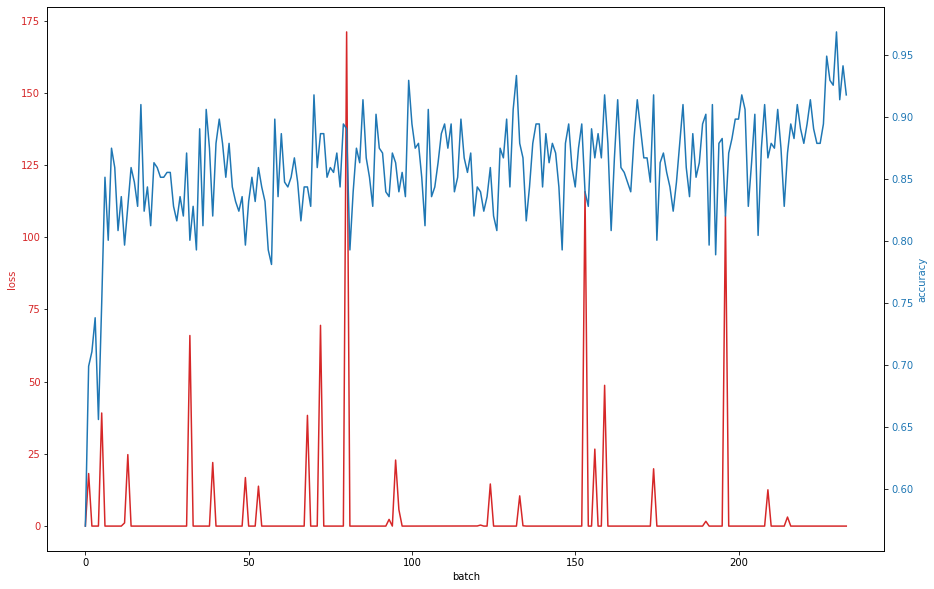

In [21]:
# plot the loss and accuracy next to each other
import matplotlib.pyplot as plt
# change size of plots
plt.rcParams["figure.figsize"] = (15,10)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(loss_vals, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_vals, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# FP16 Training

In [7]:
in_ch = 28*28
out_ch = 10
data_type = torch.float16

class LinLayer(nn.Module):
    def __init__(self):
        super(LinLayer, self).__init__()
        torch.manual_seed(42)
        self.lin = nn.Linear(in_ch, out_ch, dtype=data_type)

    def forward(self, x):
        torch.manual_seed(42)
        out = self.lin(x.view(x.size(0), -1))
        return out

In [26]:
def convert_to_target_format(data_np, prec):
    if prec == 64:
        return data_np.astype(np.float64)
    elif prec == 32:
        return data_np.astype(np.float32)
    elif prec == 16:
        return data_np.astype(np.float16)

In [24]:
NUM_EPOCHS = 1
NUM_BATCHES = 1
BATCH_SIZE = 256

net = LinLayer()
weights = net.lin.weight.data.numpy()
weights_fp16 = convert_to_target_format(weights, 16).reshape(10, 28*28)
weights_fp16_tensor = torch.from_numpy(weights_fp16)
bias = net.lin.bias.data.numpy()
bias_fp16 = convert_to_target_format(bias, 16).reshape(10)
bias_fp16_tensor = torch.from_numpy(bias_fp16)
# optimizer = optim.SGD(net.parameters(), lr=0.5)
# loss_fn = nn.CrossEntropyLoss()
accuracy = 0
batch_id = 0

loss_vals = []
acc_vals = []

it = iter(mnist_dl)
for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    for i, data in enumerate(mnist_dl, 0):
        inputs, labels = data

        linear_output_fp16 = inputs.view(-1, 28*28).to(torch.float16) @ weights_fp16_tensor.t() + bias_fp16_tensor

        softmax_output = torch.nn.Softmax(dim=1)(linear_output_fp16.to(torch.float32))
        softmax_output_fp16 = softmax_output.to(torch.float16)

        # manually determine the cross entropy loss
        cross_entropy_loss = 0.0 - np.log(softmax_output_fp16[0][labels])#-torch.sum(labels * torch.log(softmax_output), dim=1)
        # determine accuracy
        _, predicted = torch.max(softmax_output_fp16.data, 1)
        accuracy += (predicted == labels).sum().item()

        bias_grad_fp16 = softmax_output_fp16 - torch.nn.functional.one_hot(labels, num_classes=10).to(torch.float16)
        weight_grad_fp16 = bias_grad_fp16.t() @ inputs.view(-1, 28*28).to(torch.float16)

        weights_fp16_tensor = weights_fp16_tensor - 0.5 * weight_grad_fp16
        bias_fp16_tensor = bias_fp16_tensor - 0.5 * bias_grad_fp16

        # print statistics
        if i % BATCH_SIZE == BATCH_SIZE-1:
            batch_id += 1
            print("Batch: ", batch_id, "Loss: ", cross_entropy_loss.item())
            # check if cross entropy loss is nan or +/- inf
            if (np.isnan(cross_entropy_loss.item()) or np.isinf(cross_entropy_loss.item())):
                loss_vals.append(np.nan)
            else:
                loss_vals.append(cross_entropy_loss.item())
            print("Batch: ", batch_id, "Accuracy: ", accuracy / (BATCH_SIZE * NUM_BATCHES))
            acc_vals.append(accuracy / (BATCH_SIZE * NUM_BATCHES))
            accuracy = 0
    
    print("Epoch {} done".format(epoch))

Epoch:  0


<ipython-input-24-70ec9547ffe9>:32: RuntimeWarning: divide by zero encountered in log
  cross_entropy_loss = 0.0 - np.log(softmax_output_fp16[0][labels])#-torch.sum(labels * torch.log(softmax_output), dim=1)


Batch:  1 Loss:  0.0
Batch:  1 Accuracy:  0.5546875
Batch:  2 Loss:  1.8818359375
Batch:  2 Accuracy:  0.71875
Batch:  3 Loss:  0.0
Batch:  3 Accuracy:  0.72265625
Batch:  4 Loss:  0.0
Batch:  4 Accuracy:  0.73046875
Batch:  5 Loss:  0.0469970703125
Batch:  5 Accuracy:  0.69921875
Batch:  6 Loss:  inf
Batch:  6 Accuracy:  0.74609375
Batch:  7 Loss:  0.0
Batch:  7 Accuracy:  0.86328125
Batch:  8 Loss:  0.0
Batch:  8 Accuracy:  0.76171875
Batch:  9 Loss:  0.0
Batch:  9 Accuracy:  0.84765625
Batch:  10 Loss:  0.0
Batch:  10 Accuracy:  0.83984375
Batch:  11 Loss:  inf
Batch:  11 Accuracy:  0.84765625
Batch:  12 Loss:  0.0
Batch:  12 Accuracy:  0.83203125
Batch:  13 Loss:  0.0
Batch:  13 Accuracy:  0.82421875
Batch:  14 Loss:  3.98828125
Batch:  14 Accuracy:  0.80859375
Batch:  15 Loss:  0.0
Batch:  15 Accuracy:  0.84375
Batch:  16 Loss:  0.0
Batch:  16 Accuracy:  0.83984375
Batch:  17 Loss:  0.0
Batch:  17 Accuracy:  0.828125
Batch:  18 Loss:  0.0
Batch:  18 Accuracy:  0.8671875
Batch:  19

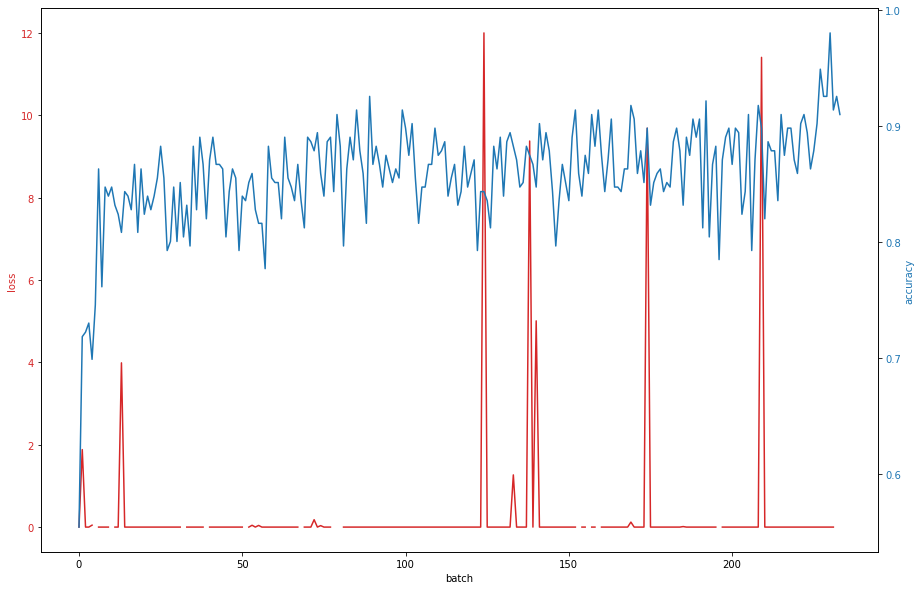

In [25]:
# plot the loss and accuracy next to each other
import matplotlib.pyplot as plt
# change size of plots
plt.rcParams["figure.figsize"] = (15,10)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(loss_vals, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_vals, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# BFloat16 Training

In [51]:
in_ch = 28*28
out_ch = 10
data_type = torch.bfloat16

class LinLayer(nn.Module):
    def __init__(self):
        super(LinLayer, self).__init__()
        torch.manual_seed(42)
        self.lin = nn.Linear(in_ch, out_ch, dtype=data_type)

    def forward(self, x):
        torch.manual_seed(42)
        out = self.lin(x.view(x.size(0), -1))
        return out

In [52]:
net = LinLayer()
weights = net.lin.weight.to(torch.bfloat16)
print(weights)

Parameter containing:
tensor([[-0.0072,  0.0142, -0.0100,  ..., -0.0084,  0.0309, -0.0259],
        [ 0.0226,  0.0312,  0.0284,  ..., -0.0284, -0.0167,  0.0053],
        [-0.0330,  0.0349, -0.0153,  ...,  0.0176, -0.0114, -0.0056],
        ...,
        [-0.0287, -0.0289,  0.0025,  ...,  0.0006,  0.0204, -0.0075],
        [-0.0178,  0.0330, -0.0025,  ..., -0.0256, -0.0008,  0.0334],
        [-0.0248, -0.0159, -0.0248,  ...,  0.0332,  0.0192, -0.0261]],
       dtype=torch.bfloat16, requires_grad=True)


In [53]:
NUM_EPOCHS = 1
NUM_BATCHES = 1
BATCH_SIZE = 256

net = LinLayer()
weights = net.lin.weight
# convert weights to bfloat16
weights_bf16 = weights.to(dtype=torch.bfloat16)
bias = net.lin.bias
# convert bias to bfloat16
bias_bf16 = bias.to(dtype=torch.bfloat16)

accuracy = 0
batch_id = 0

loss_vals = []
acc_vals = []

it = iter(mnist_dl)
for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    for i, data in enumerate(mnist_dl, 0):
        inputs, labels = data

        linear_output_bf16 = inputs.view(-1, 28*28).to(torch.bfloat16) @ weights_bf16.t() + bias_bf16

        softmax_output = torch.nn.Softmax(dim=1)(linear_output_bf16.to(torch.float32))
        softmax_output_bf16 = softmax_output.to(torch.bfloat16)

        # manually determine the cross entropy loss
        cross_entropy_loss = 0.0 - np.log(softmax_output_fp16[0][labels])#-torch.sum(labels * torch.log(softmax_output), dim=1)
        # determine accuracy
        _, predicted = torch.max(softmax_output_bf16.data, 1)
        accuracy += (predicted == labels).sum().item()

        bias_grad_bf16 = softmax_output_bf16 - torch.nn.functional.one_hot(labels, num_classes=10).to(torch.bfloat16)
        weight_grad_bf16 = bias_grad_bf16.t() @ inputs.view(-1, 28*28).to(torch.bfloat16)

        weights_bf16 = weights_bf16 - 0.5 * weight_grad_bf16
        bias_bf16 = bias_bf16 - 0.5 * bias_grad_bf16

        # print statistics
        if i % BATCH_SIZE == BATCH_SIZE-1:
            batch_id += 1
            print("Batch: ", batch_id, "Loss: ", cross_entropy_loss.item())
            # check if cross entropy loss is nan or +/- inf
            if (np.isnan(cross_entropy_loss.item()) or np.isinf(cross_entropy_loss.item())):
                loss_vals.append(np.nan)
            else:
                loss_vals.append(cross_entropy_loss.item())
            print("Batch: ", batch_id, "Accuracy: ", accuracy / (BATCH_SIZE * NUM_BATCHES))
            acc_vals.append(accuracy / (BATCH_SIZE * NUM_BATCHES))
            accuracy = 0
    
    print("Epoch {} done".format(epoch))

Epoch:  0


<ipython-input-53-c3dfebad25e4>:31: RuntimeWarning: divide by zero encountered in log
  cross_entropy_loss = 0.0 - np.log(softmax_output_fp16[0][labels])#-torch.sum(labels * torch.log(softmax_output), dim=1)


Batch:  1 Loss:  inf
Batch:  1 Accuracy:  0.52734375
Batch:  2 Loss:  inf
Batch:  2 Accuracy:  0.6953125
Batch:  3 Loss:  inf
Batch:  3 Accuracy:  0.734375
Batch:  4 Loss:  inf
Batch:  4 Accuracy:  0.76171875
Batch:  5 Loss:  0.0
Batch:  5 Accuracy:  0.71484375
Batch:  6 Loss:  inf
Batch:  6 Accuracy:  0.75390625
Batch:  7 Loss:  inf
Batch:  7 Accuracy:  0.83984375
Batch:  8 Loss:  inf
Batch:  8 Accuracy:  0.78515625
Batch:  9 Loss:  0.0
Batch:  9 Accuracy:  0.87109375
Batch:  10 Loss:  inf
Batch:  10 Accuracy:  0.83203125
Batch:  11 Loss:  inf
Batch:  11 Accuracy:  0.85546875
Batch:  12 Loss:  inf
Batch:  12 Accuracy:  0.8203125
Batch:  13 Loss:  inf
Batch:  13 Accuracy:  0.82421875
Batch:  14 Loss:  inf
Batch:  14 Accuracy:  0.828125
Batch:  15 Loss:  inf
Batch:  15 Accuracy:  0.83984375
Batch:  16 Loss:  inf
Batch:  16 Accuracy:  0.859375
Batch:  17 Loss:  inf
Batch:  17 Accuracy:  0.828125
Batch:  18 Loss:  inf
Batch:  18 Accuracy:  0.88671875
Batch:  19 Loss:  inf
Batch:  19 Accur

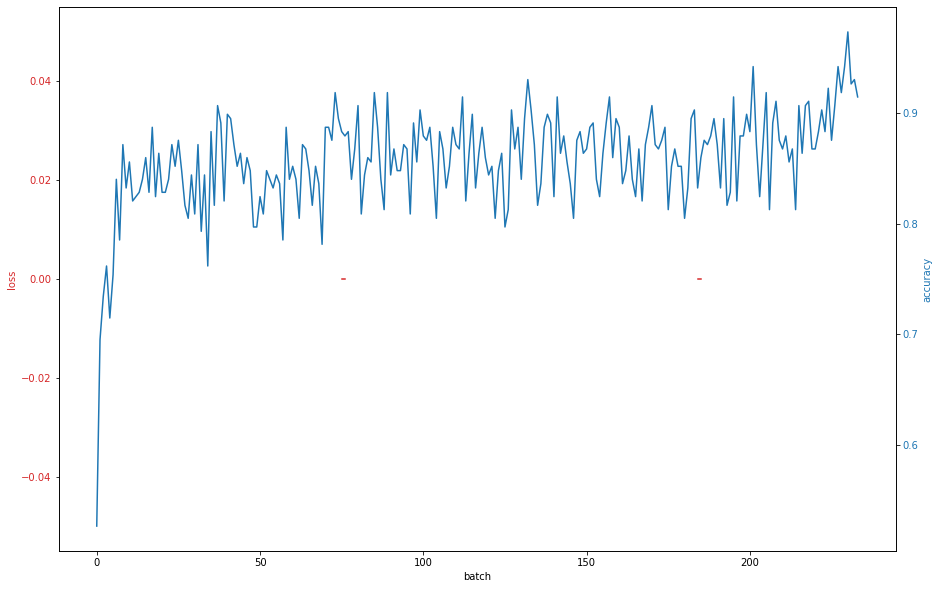

In [54]:
# plot the loss and accuracy next to each other
import matplotlib.pyplot as plt
# change size of plots
plt.rcParams["figure.figsize"] = (15,10)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(loss_vals, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_vals, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# FP8 Training

In [56]:
in_ch = 28*28
out_ch = 10
data_type = torch.float32

class LinLayer(nn.Module):
    def __init__(self):
        super(LinLayer, self).__init__()
        torch.manual_seed(42)
        self.lin = nn.Linear(in_ch, out_ch, dtype=data_type)

    def forward(self, x):
        torch.manual_seed(42)
        out = self.lin(x.view(x.size(0), -1))
        return out

In [57]:
# function to convert float32 to binary representation
import struct

def float32_to_bin(value):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', value))

In [74]:
"""
We have to handle denormalized numbers:
    
    +INF will be represented in FP8 as 0 11111 00 
    -INF will be represented in FP8 as 1 11111 00
    +0 will be represented in FP8 as 0 00000 00
    -0 will be represented in FP8 as 1 00000 00
    NaN will be represented in FP8 as X 11111 MM (at least one of the MMM bits is set, sign bit is don't care)

According to https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8556098 denormalized transprecision numbers
will be represented by their high precision counterparts. In these cases we have to make sure that we do not adjust
the exponent. In the other cases we adjust the exponent and cut the mantissa.
"""

from numpy import binary_repr

# this function returns an 8 character string representing the binary representation of the FP8 number
def float32_to_fp8(value):
    max_exp_fp32 = int('11111111', 2)
    min_exp_fp32 = int('00000000', 2)
    exp_bias_fp32 = 2 ** (8 - 1) - 1
    exp_bias_fp8 = 2 ** (5 - 1) - 1
    # get the binary representation of the number
    binstr = float32_to_bin(value)
    # extract sign, exponent and mantissa bits
    sign = binstr[0]
    exponent = binstr[1:9]
    mantissa = binstr[9:]
    # check if the number is denormalized
    # we start by checking if all exponent bits are asserted
    if(int(exponent) == max_exp_fp32):
        # if so, we check if the mantissa is all zeros (will result in +/-INF)
        if(int(mantissa) == 0):
            return sign + exponent[:5] + mantissa[:2]
        # if not, we have to return a NaN
        else:
            return sign + exponent[:5] + '01'
    # if both exponent and mantissa are zero we will return +/-0
    elif (int(exponent) == min_exp_fp32 and int(mantissa) == 0): 
        return sign + exponent[:5] + mantissa[:2]
    else :
        # if not, we adjust the exponent and cut the mantissa
        exponent_fp8 = binary_repr(int(exponent, 2) - exp_bias_fp32 + exp_bias_fp8, width=5)
        mantissa_fp8 = mantissa[:2]
        return sign + exponent_fp8 + mantissa_fp8


In [75]:
# exponent is stored in two's complement
def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val  

In [76]:
def convert_to_fp8_decimal(binstr):

    # extract sign, exponent and mantissa bits
    sign = binstr[0]
    num_sign_bits = 1
    # print(f'Sign:     ({num_sign_bits} bit)  = {sign}')
    exponent = binstr[1:6]
    num_exp_bits = len(exponent)
    # print(f'Exponent: ({num_exp_bits} bit)  = {exponent}')
    mantissa = binstr[6:]
    num_mant_bits = len(mantissa)
    # print(f'Mantissa: ({num_mant_bits} bit) = {mantissa}')

    exp_bias_fp8 = 2 ** (5 - 1) - 1
    dec_val_fp8 = (-1)**(int(sign, 2)) * (1 + (int(mantissa, 2))/(2**num_mant_bits)) * 2**(twos_comp(int(exponent, 2), num_exp_bits) - exp_bias_fp8)
    if(int(sign, 2) == 0 and int(exponent, 2) == 0 and int(mantissa, 2) == 0):
        dec_val_fp8 = 0
    # print("\nBinary to floating point number (FP8) conversion using formula: ", dec_val_fp8)
    return dec_val_fp8
    

In [77]:
# define the special FP8 values
fp8_nans = ['01111101', '01111110', '01111111', '11111101', '11111110', '11111111']
# print fp8_nans as integers
for nan in fp8_nans:
    print(f' NaN: {nan} = {int(nan, 2)}')
fp8_pinf = '01111100'
print(f'+INF: {fp8_pinf} = {int(fp8_pinf, 2)}')
fp8_ninf = '11111100'
print(f'-INF: {fp8_ninf} = {int(fp8_ninf, 2)}')

 NaN: 01111101 = 125
 NaN: 01111110 = 126
 NaN: 01111111 = 127
 NaN: 11111101 = 253
 NaN: 11111110 = 254
 NaN: 11111111 = 255
+INF: 01111100 = 124
-INF: 11111100 = 252


In [78]:
fp8_int_values = range(0, 256)
# remove the special FP8 values
fp8_int_values = [x for x in fp8_int_values if x not in [int(nan, 2) for nan in fp8_nans] + [int(fp8_pinf, 2), int(fp8_ninf, 2)]]

In [87]:
import random
def clear_special_values(data_np):
    nan_cnt = 0
    inf_cnt = 0
    for val, idx in zip(data_np, range(len(data_np))):
        if(val in [int(nan, 2) for nan in fp8_nans]):
            print(f'Found NaN at index {idx}')
            data_np[idx] = random.choice(fp8_int_values)
            print(f'Randomly replaced NaN with {data_np[idx]}')
            nan_cnt += 1
        elif(val == int(fp8_pinf, 2) or val == int(fp8_ninf, 2)):
            print(f'Found INF at index {idx}')
            data_np[idx] = random.choice(fp8_int_values)
            print(f'Randomly replaced INF with {data_np[idx]}')
            inf_cnt += 1 

    # print(f'NaN count: {nan_cnt}')
    # print(f'INF count: {inf_cnt}')

    return data_np

In [80]:
def convert_to_fp8(data_np):
    data_np = data_np.astype(np.float32)
    # convert to FP8
    data_fp8 = np.array([float32_to_fp8(val) for val in data_np])
    # clear special values
    data_fp8 = clear_special_values(data_fp8)
    return data_fp8

In [84]:
net = LinLayer()
weights = net.lin.weight
# convert weights to FP8
weights_fp8 = convert_to_fp8(weights.detach().numpy().flatten()).reshape(10, 28*28)
# convert weights back to FP8 decimal
weights_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in weights_fp8.flatten()]).reshape(10, 28*28)
# convert weights_fp8 to tensor
weights_fp8 = torch.from_numpy(weights_fp8_dec)

bias = net.lin.bias
# convert bias to FP8
bias_fp8 = convert_to_fp8(bias.detach().numpy().flatten()).reshape(10)
# convert bias back to FP8 decimal
bias_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in bias_fp8.flatten()]).reshape(10)
# convert bias_fp8 to tensor
bias_fp8 = torch.from_numpy(bias_fp8_dec)

NaN count: 0
INF count: 0
NaN count: 0
INF count: 0


In [117]:
NUM_EPOCHS = 1
NUM_BATCHES = 1
BATCH_SIZE = 256

accuracy = 0
batch_id = 0

loss_vals = []
acc_vals = []

it = iter(mnist_dl)
for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    for i, data in enumerate(mnist_dl, 0):
        inputs, labels = data

        # convert inputs to FP8
        inputs_fp8 = convert_to_fp8(inputs.flatten().detach().numpy()).reshape(1, 28*28)
        # convert inputs back to FP8 decimal
        inputs_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in inputs_fp8.flatten()]).reshape(1, 28*28)
        # convert inputs_fp8 to tensor
        inputs_fp8 = torch.from_numpy(inputs_fp8_dec)

        linear_output_fp8 = inputs_fp8 @ weights_fp8.t() + bias_fp8

        softmax_output = torch.nn.Softmax(dim=1)(linear_output_fp8.to(torch.float32))
        # convert softmax_output to FP8
        softmax_output_fp8 = convert_to_fp8(softmax_output.flatten().detach().numpy()).reshape(1, 10)
        # convert softmax_output back to FP8 decimal
        softmax_output_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in softmax_output_fp8.flatten()]).reshape(1, 10)
        # convert softmax_output_fp8 to tensor
        softmax_output_fp8 = torch.from_numpy(softmax_output_fp8_dec)

        # manually determine the cross entropy loss
        # cross_entropy_loss = 0.0 - np.log(softmax_output_fp8[0][labels])#-torch.sum(labels * torch.log(softmax_output), dim=1)
        # determine accuracy
        _, predicted = torch.max(softmax_output_fp8.data, 1)
        accuracy += (predicted == labels).sum().item()

        bias_grad_fp8 = softmax_output_fp8 - torch.nn.functional.one_hot(labels, num_classes=10)
        # convert bias_grad_fp8 to FP8
        bias_grad_fp8 = convert_to_fp8(bias_grad_fp8.flatten().detach().numpy()).reshape(1, 10)
        # convert bias_grad_fp8 back to FP8 decimal
        bias_grad_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in bias_grad_fp8.flatten()]).reshape(1, 10)
        # convert bias_grad_fp8 to tensor
        bias_grad_fp8 = torch.from_numpy(bias_grad_fp8_dec).to(torch.float64)

        weight_grad_fp8 = bias_grad_fp8.t() @ inputs_fp8
        # convert weight_grad_fp8 to FP8
        weight_grad_fp8 = convert_to_fp8(weight_grad_fp8.flatten().detach().numpy()).reshape(10, 28*28)
        # convert weight_grad_fp8 back to FP8 decimal
        weight_grad_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in weight_grad_fp8.flatten()]).reshape(10, 28*28)
        # convert weight_grad_fp8 to tensor
        weight_grad_fp8 = torch.from_numpy(weight_grad_fp8_dec).to(torch.float64)

        weights_fp8 = weights_fp8 - 0.5 * weight_grad_fp8
        # convert weights_fp8 to FP8
        weights_fp8 = convert_to_fp8(weights_fp8.flatten().detach().numpy()).reshape(10, 28*28)
        # convert weights_fp8 back to FP8 decimal
        weights_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in weights_fp8.flatten()]).reshape(10, 28*28)
        # convert weights_fp8 to tensor
        weights_fp8 = torch.from_numpy(weights_fp8_dec).to(torch.float64)

        bias_fp8 = bias_fp8 - 0.5 * bias_grad_fp8
        # convert bias_fp8 to FP8
        bias_fp8 = convert_to_fp8(bias_fp8.flatten().detach().numpy()).reshape(10)
        # convert bias_fp8 back to FP8 decimal
        bias_fp8_dec = np.array([convert_to_fp8_decimal(binstr) for binstr in bias_fp8.flatten()]).reshape(10)
        # convert bias_fp8 to tensor
        bias_fp8 = torch.from_numpy(bias_fp8_dec).to(torch.float64)

        # print statistics
        if i % BATCH_SIZE == BATCH_SIZE-1:
            batch_id += 1
            # print("Batch: ", batch_id, "Loss: ", cross_entropy_loss.item())
            # check if cross entropy loss is nan or +/- inf
            # if (np.isnan(cross_entropy_loss.item()) or np.isinf(cross_entropy_loss.item())):
            #     loss_vals.append(np.nan)
            # else:
            #     loss_vals.append(cross_entropy_loss.item())
            print("Batch: ", batch_id, "Accuracy: ", accuracy / (BATCH_SIZE * NUM_BATCHES))
            acc_vals.append(accuracy / (BATCH_SIZE * NUM_BATCHES))
            accuracy = 0
    
    print("Epoch {} done".format(epoch))

Epoch:  0


<ipython-input-74-75974be4c00f>:43: DeprecationWarning: Insufficient bit width provided. This behavior will raise an error in the future.
  exponent_fp8 = binary_repr(int(exponent, 2) - exp_bias_fp32 + exp_bias_fp8, width=5)


Batch:  1 Accuracy:  0.3671875
Batch:  2 Accuracy:  0.3671875
Batch:  3 Accuracy:  0.3046875
Batch:  4 Accuracy:  0.3515625
Batch:  5 Accuracy:  0.33203125
Batch:  6 Accuracy:  0.32421875
Batch:  7 Accuracy:  0.3828125
Batch:  8 Accuracy:  0.38671875
Batch:  9 Accuracy:  0.45703125
Batch:  10 Accuracy:  0.39453125
Batch:  11 Accuracy:  0.36328125
Batch:  12 Accuracy:  0.359375
Batch:  13 Accuracy:  0.39453125
Batch:  14 Accuracy:  0.38671875
Batch:  15 Accuracy:  0.3984375
Batch:  16 Accuracy:  0.3984375
Batch:  17 Accuracy:  0.3984375
Batch:  18 Accuracy:  0.41796875
Batch:  19 Accuracy:  0.390625
Batch:  20 Accuracy:  0.421875
Batch:  21 Accuracy:  0.421875
Batch:  22 Accuracy:  0.4140625
Batch:  23 Accuracy:  0.328125
Batch:  24 Accuracy:  0.3984375
Batch:  25 Accuracy:  0.39453125
Batch:  26 Accuracy:  0.453125
Batch:  27 Accuracy:  0.38671875
Batch:  28 Accuracy:  0.359375
Batch:  29 Accuracy:  0.33203125
Batch:  30 Accuracy:  0.42578125
Batch:  31 Accuracy:  0.3515625
Batch:  32 

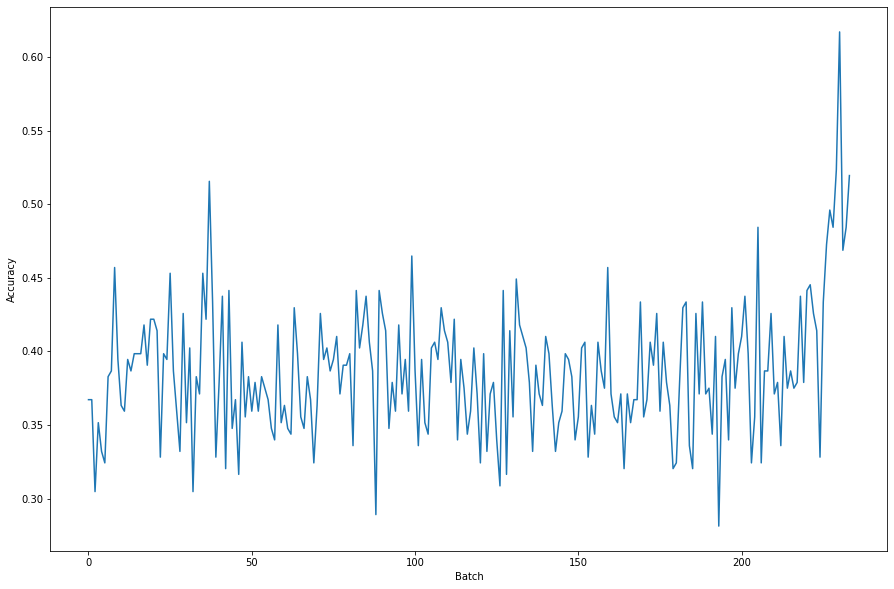

In [120]:
# plot the accuracy
plt.plot(acc_vals)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

import pickle
# save accuracy values to pickle file
with open("acc_vals_fp8.pkl", "wb") as f:
    pickle.dump(acc_vals, f)

# FP8ALT Training

In [119]:
in_ch = 28*28
out_ch = 10
data_type = torch.float32

class LinLayer(nn.Module):
    def __init__(self):
        super(LinLayer, self).__init__()
        torch.manual_seed(42)
        self.lin = nn.Linear(in_ch, out_ch, dtype=data_type)

    def forward(self, x):
        torch.manual_seed(42)
        out = self.lin(x.view(x.size(0), -1))
        return out

In [143]:
"""

FP8ALT format: 1 sign bit, 4 exponent bits, 3 mantissa bits

We have to handle denormalized numbers:
    
    +INF will be represented in FP8 as 0 1111 000 
    -INF will be represented in FP8 as 1 1111 000
    +0 will be represented in FP8 as 0 0000 000
    -0 will be represented in FP8 as 1 0000 000
    NaN will be represented in FP8 as X 1111 MMM (at least one of the MMM bits is set, sign bit is don't care)

According to https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8556098 denormalized transprecision numbers
will be represented by their high precision counterparts. In these cases we have to make sure that we do not adjust
the exponent. In the other cases we adjust the exponent and cut the mantissa.
"""

from numpy import binary_repr

# this function returns an 8 character string representing the binary representation of the FP8 number
def float32_to_fp8alt(value):
    max_exp_fp32 = int('11111111', 2)
    min_exp_fp32 = int('00000000', 2)
    exp_bias_fp32 = 2 ** (8 - 1) - 1
    exp_bias_fp8 = 2 ** (4 - 1) - 1
    # get the binary representation of the number
    binstr = float32_to_bin(value)
    # extract sign, exponent and mantissa bits
    sign = binstr[0]
    exponent = binstr[1:9]
    mantissa = binstr[9:]
    # check if the number is denormalized
    # we start by checking if all exponent bits are asserted
    if(int(exponent) == max_exp_fp32):
        # if so, we check if the mantissa is all zeros (will result in +/-INF)
        if(int(mantissa) == 0):
            return sign + exponent[:4] + mantissa[:3]
        # if not, we have to return a NaN
        else:
            return sign + exponent[:4] + '001'
    # if both exponent and mantissa are zero we will return +/-0
    elif (int(exponent) == min_exp_fp32 and int(mantissa) == 0): 
        return sign + exponent[:4] + mantissa[:3]
    else :
        # if not, we adjust the exponent and cut the mantissa
        exp = int(exponent, 2) - exp_bias_fp32 + exp_bias_fp8
        if(exp > 7):
            # print("Overflow")
            return sign + '0111' + mantissa[:3]
        elif(exp < -8):
            # print("Underflow")
            return sign + '1000' + mantissa[:3]

        exponent_fp8 = binary_repr(int(exponent, 2) - exp_bias_fp32 + exp_bias_fp8, width=4)
        mantissa_fp8 = mantissa[:3]
        return sign + exponent_fp8 + mantissa_fp8


In [126]:
# exponent is stored in two's complement
def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val  

In [127]:
def convert_to_fp8alt_decimal(binstr):

    # extract sign, exponent and mantissa bits
    sign = binstr[0]
    num_sign_bits = 1
    # print(f'Sign:     ({num_sign_bits} bit)  = {sign}')
    exponent = binstr[1:5]
    num_exp_bits = len(exponent)
    # print(f'Exponent: ({num_exp_bits} bit)  = {exponent}')
    mantissa = binstr[5:]
    num_mant_bits = len(mantissa)
    # print(f'Mantissa: ({num_mant_bits} bit) = {mantissa}')

    exp_bias_fp8 = 2 ** (4 - 1) - 1
    dec_val_fp8 = (-1)**(int(sign, 2)) * (1 + (int(mantissa, 2))/(2**num_mant_bits)) * 2**(twos_comp(int(exponent, 2), num_exp_bits) - exp_bias_fp8)
    if(int(sign, 2) == 0 and int(exponent, 2) == 0 and int(mantissa, 2) == 0):
        dec_val_fp8 = 0
    # print("\nBinary to floating point number (FP8) conversion using formula: ", dec_val_fp8)
    return dec_val_fp8
    

In [138]:
exp_min = '1000'
# get two's complement of the exponent
exp_min = twos_comp(int(exp_min, 2), 4)
print("exp_min = ", exp_min)
exp_max = '0111'
# get two's complement of the exponent
exp_max = twos_comp(int(exp_max, 2), 4)
print("exp_max = ", exp_max)

exp_min =  -8
exp_max =  7


In [128]:
# define the special FP8 values
fp8alt_nans = ['11111111', '11111110', '11111101', '11111100', '11111011', '11111001', '01111001', '01111011', '01111100', '01111101', '01111110', '01111111']
# print fp8_nans as integers
for nan in fp8_nans:
    print(f' NaN: {nan} = {int(nan, 2)}')
fp8alt_pinf = '01111000'
print(f'+INF: {fp8_pinf} = {int(fp8_pinf, 2)}')
fp8alt_ninf = '11111000'
print(f'-INF: {fp8_ninf} = {int(fp8_ninf, 2)}')

 NaN: 01111101 = 125
 NaN: 01111110 = 126
 NaN: 01111111 = 127
 NaN: 11111101 = 253
 NaN: 11111110 = 254
 NaN: 11111111 = 255
+INF: 01111100 = 124
-INF: 11111100 = 252


In [129]:
fp8alt_int_values = range(0, 256)
# remove the special FP8 values
fp8alt_int_values = [x for x in fp8alt_int_values if x not in [int(nan, 2) for nan in fp8alt_nans] + [int(fp8alt_pinf, 2), int(fp8alt_ninf, 2)]]

In [130]:
import random
def clear_special_values(data_np):
    nan_cnt = 0
    inf_cnt = 0
    for val, idx in zip(data_np, range(len(data_np))):
        if(val in [int(nan, 2) for nan in fp8alt_nans]):
            print(f'Found NaN at index {idx}')
            data_np[idx] = random.choice(fp8alt_int_values)
            print(f'Randomly replaced NaN with {data_np[idx]}')
            nan_cnt += 1
        elif(val == int(fp8_pinf, 2) or val == int(fp8_ninf, 2)):
            print(f'Found INF at index {idx}')
            data_np[idx] = random.choice(fp8alt_int_values)
            print(f'Randomly replaced INF with {data_np[idx]}')
            inf_cnt += 1 

    # print(f'NaN count: {nan_cnt}')
    # print(f'INF count: {inf_cnt}')

    return data_np

In [131]:
def convert_to_fp8alt(data_np):
    data_np = data_np.astype(np.float32)
    # convert to FP8
    data_fp8alt = np.array([float32_to_fp8alt(val) for val in data_np])
    # clear special values
    data_fp8alt = clear_special_values(data_fp8alt)
    return data_fp8alt

In [144]:
net = LinLayer()
weights = net.lin.weight
# convert weights to FP8
weights_fp8alt = convert_to_fp8alt(weights.detach().numpy().flatten()).reshape(10, 28*28)
# print(f'FP8 weights: {weights_fp8alt}')
# convert weights back to FP8 decimal
weights_fp8alt_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in weights_fp8alt.flatten()]).reshape(10, 28*28)
# convert weights_fp8alt to tensor
weights_fp8alt = torch.from_numpy(weights_fp8alt_dec)

bias = net.lin.bias
# convert bias to FP8
bias_fp8alt = convert_to_fp8alt(bias.detach().numpy().flatten()).reshape(10)
# convert bias back to FP8 decimal
bias_fp8alt_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in bias_fp8alt.flatten()]).reshape(10)
# convert bias_fp8alt to tensor
bias_fp8alt = torch.from_numpy(bias_fp8alt_dec)

In [145]:
NUM_EPOCHS = 1
NUM_BATCHES = 1
BATCH_SIZE = 256

accuracy = 0
batch_id = 0

loss_vals = []
acc_vals = []

it = iter(mnist_dl)
for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    for i, data in enumerate(mnist_dl, 0):
        inputs, labels = data

        # convert inputs to FP8
        inputs_fp8alt = convert_to_fp8alt(inputs.flatten().detach().numpy()).reshape(1, 28*28)
        # convert inputs back to FP8 decimal
        inputs_fp8alt_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in inputs_fp8alt.flatten()]).reshape(1, 28*28)
        # convert inputs_fp8alt to tensor
        inputs_fp8alt = torch.from_numpy(inputs_fp8alt_dec)

        linear_output_fp8alt = inputs_fp8alt @ weights_fp8alt.t() + bias_fp8alt

        softmax_output = torch.nn.Softmax(dim=1)(linear_output_fp8alt.to(torch.float32))
        # convert softmax_output to FP8
        softmax_output_fp8 = convert_to_fp8alt(softmax_output.flatten().detach().numpy()).reshape(1, 10)
        # convert softmax_output back to FP8 decimal
        softmax_output_fp8_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in softmax_output_fp8.flatten()]).reshape(1, 10)
        # convert softmax_output_fp8 to tensor
        softmax_output_fp8 = torch.from_numpy(softmax_output_fp8_dec)

        # manually determine the cross entropy loss
        # cross_entropy_loss = 0.0 - np.log(softmax_output_fp8[0][labels])#-torch.sum(labels * torch.log(softmax_output), dim=1)
        # determine accuracy
        _, predicted = torch.max(softmax_output_fp8.data, 1)
        accuracy += (predicted == labels).sum().item()

        bias_grad_fp8 = softmax_output_fp8 - torch.nn.functional.one_hot(labels, num_classes=10)
        # convert bias_grad_fp8 to FP8
        bias_grad_fp8 = convert_to_fp8alt(bias_grad_fp8.flatten().detach().numpy()).reshape(1, 10)
        # convert bias_grad_fp8 back to FP8 decimal
        bias_grad_fp8_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in bias_grad_fp8.flatten()]).reshape(1, 10)
        # convert bias_grad_fp8 to tensor
        bias_grad_fp8 = torch.from_numpy(bias_grad_fp8_dec).to(torch.float64)

        weight_grad_fp8 = bias_grad_fp8.t() @ inputs_fp8alt
        # convert weight_grad_fp8 to FP8
        weight_grad_fp8 = convert_to_fp8alt(weight_grad_fp8.flatten().detach().numpy()).reshape(10, 28*28)
        # convert weight_grad_fp8 back to FP8 decimal
        weight_grad_fp8_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in weight_grad_fp8.flatten()]).reshape(10, 28*28)
        # convert weight_grad_fp8 to tensor
        weight_grad_fp8 = torch.from_numpy(weight_grad_fp8_dec).to(torch.float64)

        weights_fp8alt = weights_fp8alt - 0.5 * weight_grad_fp8
        # convert weights_fp8alt to FP8
        weights_fp8alt = convert_to_fp8alt(weights_fp8alt.flatten().detach().numpy()).reshape(10, 28*28)
        # convert weights_fp8alt back to FP8 decimal
        weights_fp8alt_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in weights_fp8alt.flatten()]).reshape(10, 28*28)
        # convert weights_fp8alt to tensor
        weights_fp8alt = torch.from_numpy(weights_fp8alt_dec).to(torch.float64)

        bias_fp8alt = bias_fp8alt - 0.5 * bias_grad_fp8
        # convert bias_fp8alt to FP8
        bias_fp8alt = convert_to_fp8alt(bias_fp8alt.flatten().detach().numpy()).reshape(10)
        # convert bias_fp8alt back to FP8 decimal
        bias_fp8alt_dec = np.array([convert_to_fp8alt_decimal(binstr) for binstr in bias_fp8alt.flatten()]).reshape(10)
        # convert bias_fp8alt to tensor
        bias_fp8alt = torch.from_numpy(bias_fp8alt_dec).to(torch.float64)

        # print statistics
        if i % BATCH_SIZE == BATCH_SIZE-1:
            batch_id += 1
            # print("Batch: ", batch_id, "Loss: ", cross_entropy_loss.item())
            # check if cross entropy loss is nan or +/- inf
            # if (np.isnan(cross_entropy_loss.item()) or np.isinf(cross_entropy_loss.item())):
            #     loss_vals.append(np.nan)
            # else:
            #     loss_vals.append(cross_entropy_loss.item())
            print("Batch: ", batch_id, "Accuracy: ", accuracy / (BATCH_SIZE * NUM_BATCHES))
            acc_vals.append(accuracy / (BATCH_SIZE * NUM_BATCHES))
            accuracy = 0
    
    print("Epoch {} done".format(epoch))

Epoch:  0
Batch:  1 Accuracy:  0.40234375
Batch:  2 Accuracy:  0.44921875
Batch:  3 Accuracy:  0.42578125
Batch:  4 Accuracy:  0.45703125
Batch:  5 Accuracy:  0.39453125
Batch:  6 Accuracy:  0.39453125
Batch:  7 Accuracy:  0.5390625
Batch:  8 Accuracy:  0.47265625
Batch:  9 Accuracy:  0.5234375
Batch:  10 Accuracy:  0.47265625
Batch:  11 Accuracy:  0.4453125
Batch:  12 Accuracy:  0.484375
Batch:  13 Accuracy:  0.48046875
Batch:  14 Accuracy:  0.44140625
Batch:  15 Accuracy:  0.48828125
Batch:  16 Accuracy:  0.51171875
Batch:  17 Accuracy:  0.47265625
Batch:  18 Accuracy:  0.47265625
Batch:  19 Accuracy:  0.4296875
Batch:  20 Accuracy:  0.50390625
Batch:  21 Accuracy:  0.48046875
Batch:  22 Accuracy:  0.5234375
Batch:  23 Accuracy:  0.421875
Batch:  24 Accuracy:  0.49609375
Batch:  25 Accuracy:  0.50390625
Batch:  26 Accuracy:  0.54296875
Batch:  27 Accuracy:  0.47265625
Batch:  28 Accuracy:  0.43359375
Batch:  29 Accuracy:  0.43359375
Batch:  30 Accuracy:  0.46484375
Batch:  31 Accurac